In [141]:
import pybamm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy import constants
from pybamm import Scalar

current_directory = os.getcwd()

parameter_values = pybamm.ParameterValues("Chen2020") # 
options = {"thermal": "lumped","lithium plating": "irreversible","SEI":"ec reaction limited", "SEI film resistance":"average", "SEI porosity change": "true","loss of active material": "stress-driven","particle mechanics":"swelling only"}
parameter_values = pybamm.ParameterValues("Chen2020")
model = pybamm.lithium_ion.SPM(options=options)

In [142]:
#thermal parameters update
parameter_values.update({"Negative electrode OCP entropic change [V.K-1]": -0.0002,
                         "Positive electrode OCP entropic change [V.K-1]": -0.0004,
                         "Contact resistance [Ohm]": 0.001,
                         "Total heat transfer coefficient [W.m-2.K-1]": 10.0,
                         "Cell cooling surface area [m2]": 0.00531,
                         "Cell volume [m3]": 2.42e-05,
                         "Cell thermal expansion coefficient [m.K-1]": 1.1e-06,})

In [143]:
pybamm.constants.R

Scalar(-0x78da1089ab5ddd88, 8.314462618, children=[], domains={})

In [144]:
#TempK = model.variables["Cell temperature [K]"]
def ec_diffusivity(T_amb):
    D_sj = 2.5e-22*4
    EaD = 50000
    arrhenius = np.exp(EaD / pybamm.constants.R *(1/ 298.15 - 1/ T_amb))
    return D_sj * arrhenius
parameter_values.update({"EC diffusivity [m2.s-1]": ec_diffusivity})

In [145]:
#sei parameters update
parameter_values.update({"SEI kinetic rate constant [m.s-1]": 1e-12*0.002})
# parameter_values.update({"Ratio of lithium moles to SEI moles": 1.0*2})
# parameter_values.update({"Inner SEI partial molar volume [m3.mol-1]": 9.585e-05*0.5})
#parameter_values.update({"Outer SEI partial molar volume [m3.mol-1]": 9.585e-05*0.5})
# parameter_values.update({"SEI resistivity [Ohm.m]": 200000.0*0.1})
#parameter_values.update({"EC diffusivity [m2.s-1]": 2e-18*0+2.5e-22*4})
# parameter_values.update({"EC initial concentration in electrolyte [mol.m-3]": 4541.0*1})
# parameter_values.update({"SEI growth activation energy [J.mol-1]": 38000.0*0})

In [146]:
def graphite_volume_change_Ai2020(sto, c_s_max):
    """
    Graphite particle volume change as a function of stochiometry [1, 2].

    References
    ----------
     .. [1] Ai, W., Kraft, L., Sturm, J., Jossen, A., & Wu, B. (2020).
     Electrochemical Thermal-Mechanical Modelling of Stress Inhomogeneity in
     Lithium-Ion Pouch Cells. Journal of The Electrochemical Society, 167(1), 013512
      DOI: 10.1149/2.0122001JES.
     .. [2] Rieger, B., Erhard, S. V., Rumpf, K., & Jossen, A. (2016).
     A new method to model the thickness change of a commercial pouch cell
     during discharge. Journal of The Electrochemical Society, 163(8), A1566-A1575.

    Parameters
    ----------
    sto: :class:`pybamm.Symbol`
        Electrode stochiometry, dimensionless
        should be R-averaged particle concentration
    Returns
    -------
    t_change:class:`pybamm.Symbol`
        volume change, dimensionless, normalised by particle volume
    """
    p1 = 145.907
    p2 = -681.229
    p3 = 1334.442
    p4 = -1415.710
    p5 = 873.906
    p6 = -312.528
    p7 = 60.641
    p8 = -5.706
    p9 = 0.386
    p10 = -4.966e-05
    t_change = (
        p1 * sto**9
        + p2 * sto**8
        + p3 * sto**7
        + p4 * sto**6
        + p5 * sto**5
        + p6 * sto**4
        + p7 * sto**3
        + p8 * sto**2
        + p9 * sto
        + p10
    )
    return t_change

In [147]:
def volume_change_Ai2020(sto, c_s_max):
    """
    Particle volume change as a function of stochiometry [1, 2].

    References
    ----------
     .. [1] > Ai, W., Kraft, L., Sturm, J., Jossen, A., & Wu, B. (2020).
     Electrochemical Thermal-Mechanical Modelling of Stress Inhomogeneity in
     Lithium-Ion Pouch Cells. Journal of The Electrochemical Society, 167(1), 013512
      DOI: 10.1149/2.0122001JES.
     .. [2] > Rieger, B., Erhard, S. V., Rumpf, K., & Jossen, A. (2016).
     A new method to model the thickness change of a commercial pouch cell
     during discharge. Journal of The Electrochemical Society, 163(8), A1566-A1575.

    Parameters
    ----------
    sto: :class:`pybamm.Symbol`
        Electrode stochiometry, dimensionless
        should be R-averaged particle concentration
    Returns
    -------
    t_change:class:`pybamm.Symbol`
        volume change, dimensionless, normalised by particle volume
    """
    omega = pybamm.Parameter("Positive electrode partial molar volume [m3.mol-1]")
    t_change = omega * c_s_max * sto
    return t_change

In [148]:
# LAM parameters update

parameter_values.update({"Positive electrode LAM constant proportional term [s-1]": 0.1/3600,
                         "Negative electrode LAM constant proportional term [s-1]": 0.5/3600,
                         
                         "Positive electrode LAM constant exponential term": 2.0*1.1,
                         "Negative electrode critical stress [Pa]": 60000000.0*1,
                         "Negative electrode LAM constant exponential term": 2.0*1.1,
                         "Positive electrode critical stress [Pa]": 375000000.0*1,
                         "Positive electrode partial molar volume [m3.mol-1]": 1.25e-05,
                         "Negative electrode partial molar volume [m3.mol-1]": 3.1e-06,
                         "Negative electrode Young's modulus [Pa]": 15000000000.0,
                         "Negative electrode Poisson's ratio": 0.3,
                         "Positive electrode Poisson's ratio": 0.2,
                         "Positive electrode Young's modulus [Pa]": 375000000000.0,
                         "Negative electrode reference concentration for free of deformation [mol.m-3]"
                         "": 0.0,
                         "Positive electrode reference concentration for free of deformation [mol.m-3]"
                         "": 0.0,
                         "Negative electrode volume change": graphite_volume_change_Ai2020,
                         "Positive electrode volume change": volume_change_Ai2020,}, check_already_exists=False)

#parameter_values.update({"Positive electrode LAM constant exponential term": 2.0*1.1})
#parameter_values.update({"Negative electrode critical stress [Pa]": 60000000.0*0.0009})
#parameter_values.update({"Negative electrode LAM constant exponential term": 2.0*1.1})

#parameter_values.update({"Positive electrode critical stress [Pa]": 375000000.0*0.00001})




In [149]:
def plating_exchange_current_density_OKane2020(c_e, c_Li, T):
    """
    Exchange-current density for Li plating reaction [A.m-2].
    References
    ----------
    .. [1] O’Kane, Simon EJ, Ian D. Campbell, Mohamed WJ Marzook, Gregory J. Offer, and
    Monica Marinescu. "Physical origin of the differential voltage minimum associated
    with lithium plating in Li-ion batteries." Journal of The Electrochemical Society
    167, no. 9 (2020): 090540.
    Parameters
    ----------
    c_e : :class:`pybamm.Symbol`
        Electrolyte concentration [mol.m-3]
    c_Li : :class:`pybamm.Symbol`
        Plated lithium concentration [mol.m-3]
    T : :class:`pybamm.Symbol`
        Temperature [K]
    Returns
    -------
    :class:`pybamm.Symbol`
        Exchange-current density [A.m-2]
    """

    k_plating = pybamm.Parameter("Lithium plating kinetic rate constant [m.s-1]")

    return pybamm.constants.F * k_plating * c_e

In [150]:
#Plating paremeters update
parameter_values.update({"Typical plated lithium concentration [mol.m-3]": 1000.0,
                        "Lithium metal partial molar volume [m3.mol-1]": 1.3e-05,
                        "Exchange-current density for plating [A.m-2]"
                        "": plating_exchange_current_density_OKane2020,
                        "Lithium plating kinetic rate constant [m.s-1]": 1e-09*0.0001,
                        "Lithium plating transfer coefficient": 0.65,
                        "Initial plated lithium concentration [mol.m-3]": 0.0,}, check_already_exists=False)


In [169]:
from itertools import product


temp_list = [25, 45] #25,
crate_list = [0.3] #,[0.1,0.3, 1]
soc_list = [10, 60, 100] #,[10, 60, 100] 
dod_list = [90] #60, 70,[50, 70, 90]

all_cases = list(product(temp_list, crate_list, soc_list, dod_list))

df = pd.DataFrame(all_cases,columns = ["Temperature", "C_rate", "SoC", "DoD"])
df.insert(0, "Case", range(1, len(df)+1))
df.to_csv(f"{current_directory}/ageingresults3/Cases_for_ageing.csv", index=False)

In [170]:
df

,Case,Temperature,C_rate,SoC,DoD
0,1,25,0.3,10,90
1,2,25,0.3,60,90
2,3,25,0.3,100,90
3,4,45,0.3,10,90
4,5,45,0.3,60,90
5,6,45,0.3,100,90


Cycling:   9%|▉         | 506/5475 [01:02<08:39,  9.57it/s]At t = 265.483 repeated recoverable right-hand side function errors.
2024-07-12 06:36:30.525 - [ERROR] callbacks.on_experiment_error(228): Simulation error: Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1432:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:361:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_REPTD_RHSFUNC_ERR". Consult CVODES documentation.
Cycling:   9%|▉         | 507/5475 [01:02<10:13,  8.10it/s]


Took 599.413 ms


Cycling:   9%|▉         | 501/5475 [00:35<07:54, 10.49it/s]At t = 270.272 repeated recoverable right-hand side function errors.
2024-07-12 06:37:10.512 - [ERROR] callbacks.on_experiment_error(228): Simulation error: Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1432:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:361:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_REPTD_RHSFUNC_ERR". Consult CVODES documentation.
Cycling:   9%|▉         | 501/5475 [00:36<05:57, 13.90it/s]


Took 529.733 ms


Cycling:  12%|█▏        | 633/5475 [00:52<07:56, 10.15it/s]At t = 184.287 and h = 7.32966e-08, the corrector convergence test failed repeatedly or with |h| = hmin.
At t = 184.287 and h = 7.32966e-08, the corrector convergence test failed repeatedly or with |h| = hmin.
Cycling:  12%|█▏        | 667/5475 [00:55<08:08,  9.84it/s]At t = 203.466 repeated recoverable right-hand side function errors.
2024-07-12 06:38:07.624 - [ERROR] callbacks.on_experiment_error(228): Simulation error: Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1432:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:361:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_REPTD_RHSFUNC_ERR". Consult CVODES documentation.
Cycling:  12%|█▏        | 667/5475 [00:55<06:42, 11.96it/s]


Took 1.347 s


Cycling:  10%|▉         | 543/5475 [00:46<08:52,  9.26it/s]At t = 218.353 repeated recoverable right-hand side function errors.
At t = 218.353 repeated recoverable right-hand side function errors.
At t = 174.892 repeated recoverable right-hand side function errors.
Cycling:  10%|█         | 569/5475 [00:49<09:59,  8.18it/s]At t = 867.187 repeated recoverable right-hand side function errors.
At t = 245.84 repeated recoverable right-hand side function errors.
Cycling:  10%|█         | 573/5475 [00:50<08:59,  9.09it/s]At t = 221.849 and h = 1.55169e-07, the corrector convergence test failed repeatedly or with |h| = hmin.
2024-07-12 06:39:01.731 - [ERROR] callbacks.on_experiment_error(228): Simulation error: Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1432:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:361:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_CONV_FAILURE". Consult CVODES docum

Took 709.331 ms


Cycling:  10%|▉         | 534/5475 [00:38<08:19,  9.90it/s]At t = 309.598 repeated recoverable right-hand side function errors.
At t = 189.019 repeated recoverable right-hand side function errors.
2024-07-12 06:39:44.838 - [ERROR] callbacks.on_experiment_error(228): Simulation error: Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1432:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:361:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_REPTD_RHSFUNC_ERR". Consult CVODES documentation.
Cycling:  10%|▉         | 534/5475 [00:39<06:02, 13.64it/s]


Took 501.446 ms


Cycling:  12%|█▏        | 679/5475 [00:58<16:20,  4.89it/s]At t = 763.287 and h = 1.66039e-06, the corrector convergence test failed repeatedly or with |h| = hmin.
At t = 291.929 and h = 3.59246e-07, the corrector convergence test failed repeatedly or with |h| = hmin.
2024-07-12 06:40:45.505 - [ERROR] callbacks.on_experiment_error(228): Simulation error: Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:1432:
Error in Function::call for 'F' [CvodesInterface] at .../casadi/core/function.cpp:361:
.../casadi/interfaces/sundials/cvodes_interface.cpp:392: CVode returned "CV_CONV_FAILURE". Consult CVODES documentation.
Cycling:  12%|█▏        | 679/5475 [00:59<06:59, 11.44it/s]


Took 951.809 ms


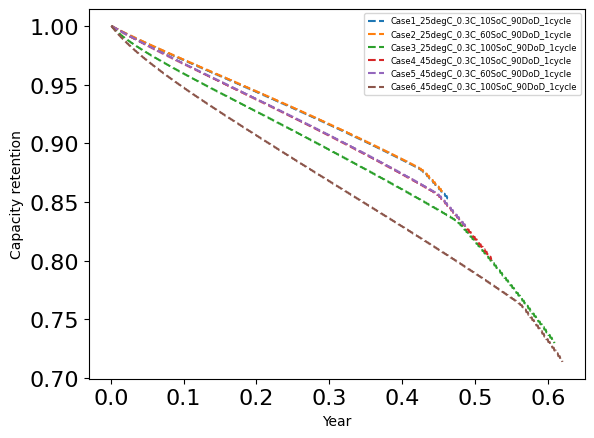

In [171]:
atol = 1e-6
rtol = 1e-6
dt_max = 1000
cycles_per_day = 1
days_per_year = 365
years_for_sim = 5
termination_capacity = 60
time_per_cycle = 24/cycles_per_day #in hours
soc_upper_cutoff = 1
soc_lower_cutoff = 0
max_dod = soc_upper_cutoff - soc_lower_cutoff
crate_ref = 0.1
period_charge_discharge = 5
period_rest = 60
safe_solver = pybamm.CasadiSolver(atol=atol, rtol=rtol, mode="safe", dt_max= dt_max)

df_conditions = {}
df_conditions = pd.DataFrame(df_conditions)
simcase_list = []
experiment_list = []
no_steps_list = []

for n in range(len(df)): #[11]: #
    tempC_case = df["Temperature"][n]
    simcase = df["Case"][n]
    dod_case = df["DoD"][n]*0.01
    soc_case = df["SoC"][n]*0.01
    crate = df["C_rate"][n]
    
    parameter_values.update({"Ambient temperature [K]": 298.15 + tempC_case,
                            "Initial temperature [K]": 298.15 + tempC_case})

    t_soc0 = (1-soc_case)*60/crate_ref #time in minutes
    # exp0 = pybamm.Experiment([(f"Charge at {crate_ref}C until 4.2V", "Hold at 4.2V until 50 mA", f"Discharge at {crate_ref}C for {t_soc0} minutes")])
    # sim0 = pybamm.Simulation(model=model, parameter_values= parameter_values, experiment=exp0)
    # sol0 = sim0.solve()

    if soc_case == 1:
        model1 = model  #.set_initial_conditions_from(sol0)
    else:
        exp0 = pybamm.Experiment([(f"Charge at {crate_ref}C until 4.2V", "Hold at 4.2V until 50 mA", f"Discharge at {crate_ref}C for {t_soc0} minutes")])
        sim0 = pybamm.Simulation(model=model, parameter_values= parameter_values, experiment=exp0)
        sol0 = sim0.solve()
        model1 = model.set_initial_conditions_from(sol0)
        

    discharge_time = int(60/crate*dod_case) # in minutes
    charge_time = int(60/crate*dod_case) # in minutes
    rest_time = int(time_per_cycle*60) - discharge_time - charge_time

    discharge_string = f"Discharge at {crate}C for {discharge_time} min or until 2.5V ({period_charge_discharge} minute period)"
    charge_string = f"Charge at {crate}C for {charge_time} min or until 4.2V ({period_charge_discharge} minute period)"
    rest_string = f"Rest for {rest_time} min ({period_rest} minute period)"


    if (soc_case-dod_case) >= soc_lower_cutoff:
        list_of_steps_auto = list([discharge_string, charge_string, rest_string])
    elif (soc_case+dod_case)<= soc_upper_cutoff:
        list_of_steps_auto = list([charge_string, discharge_string, rest_string])
    elif soc_case ==0.5 and dod_case > soc_case:
        discharge_to_soc_time = int(60/crate*(dod_case-soc_case))
        updated_rest_time = rest_time - discharge_to_soc_time
        discharge_to_soc_string = f"Discharge at {crate}C for {discharge_to_soc_time} minutes ({period_charge_discharge} minute period)"
        updated_rest_string = f"Rest for {updated_rest_time} minutes ({period_rest}) minute period)"
        
        list_of_steps_auto = list([discharge_string, charge_string, updated_rest_string]) # discharge_to_soc_string,
        
    steps_total = len(list_of_steps_auto)
        
    simcase_list.append(f"Case {simcase}: {tempC_case}degC, {soc_case*100}%SoC, {crate}C, {dod_case*100}%DoD, {cycles_per_day}cycles")
    no_steps_list.append(steps_total)
    experiment_list.append(list_of_steps_auto)
    exp1 = pybamm.Experiment(list_of_steps_auto*cycles_per_day*days_per_year*years_for_sim, termination=f"{termination_capacity}% capacity")
    sim1 = pybamm.Simulation(model=model1, parameter_values=parameter_values, experiment=exp1, solver=safe_solver)
    sol1 = sim1.solve(showprogress=True, save_at_cycles=50)
    print("Took", sol1.solve_time)
    
    Q1 = sim1.solution.summary_variables["Capacity [A.h]"]
    cycle1 = sim1.solution.summary_variables["Cycle number"]
    df2 = {}
    df2 = pd.DataFrame(df2)
    df2["Days"] =cycle1/(steps_total*cycles_per_day)
    df2["Capacity Retention"] = Q1/Q1[0]
    df2.to_csv(f"{current_directory}/ageingresults3/Case{simcase}_{tempC_case}degC_{crate}C_{soc_case*100}SoC_{dod_case*100}DoD_{cycles_per_day}cycle.csv")

    plt.plot(cycle1/(steps_total*cycles_per_day)/days_per_year,Q1/Q1[0],"--", label =f"Case{simcase}_{tempC_case}degC_{crate}C_{int(soc_case*100)}SoC_{int(dod_case*100)}DoD_{cycles_per_day}cycle")
    plt.legend(fontsize=6)

plt.xlabel("Year")
plt.ylabel("Capacity retention")
plt.xticks(fontsize =16)
plt.yticks(fontsize = 16)
plt.show()

df_conditions["simcase"] = simcase_list
df_conditions["Experiment"] = experiment_list
df_conditions["n_steps"] = no_steps_list

df_conditions.to_csv(f"{current_directory}/ageingresults3/experiments1.csv")



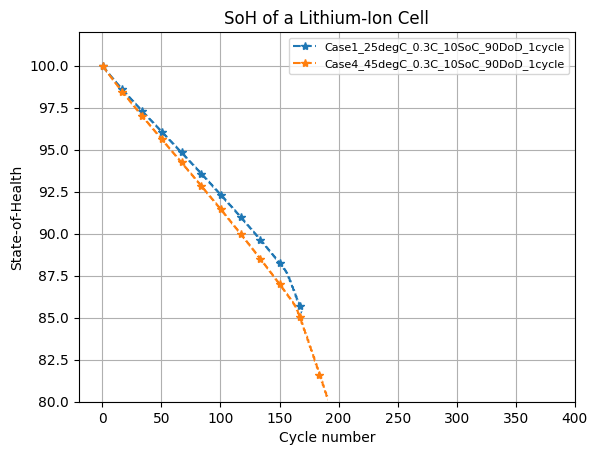

In [178]:
df3 = pd.read_csv(f"{current_directory}/ageingresults3/Cases_for_ageing.csv")
cycles_per_day =1
for n in [0, 3]: #range(len(df)): #range(5): #
    tempC_case = df3["Temperature"][n]
    simcase = df3["Case"][n]
    dod_case = df3["DoD"][n]*0.01
    soc_case = df3["SoC"][n]*0.01
    crate = df3["C_rate"][n]
    df4 = pd.read_csv(f"{current_directory}/ageingresults3/Case{simcase}_{tempC_case}degC_{crate}C_{soc_case*100}SoC_{dod_case*100}DoD_{cycles_per_day}cycle.csv")
    plt.plot(df4["Days"], df4["Capacity Retention"]*100,"--*", markevery=50,label =f"Case{simcase}_{tempC_case}degC_{crate}C_{int(soc_case*100)}SoC_{int(dod_case*100)}DoD_{cycles_per_day}cycle")

for n in [3,5]: #range(len(df)): #range(5): #
    tempC_case = df3["Temperature"][n]
    simcase = df3["Case"][n]
    dod_case = df3["DoD"][n]*0.01
    soc_case = df3["SoC"][n]*0.01
    crate = df3["C_rate"][n]
    df4 = pd.read_csv(f"{current_directory}/ageingresults3/Case{simcase}_{tempC_case}degC_{crate}C_{soc_case*100}SoC_{dod_case*100}DoD_{cycles_per_day}cycle.csv")
    #plt.plot(df4["Days"], df4["Capacity Retention"]*100,"--", label =f"Case{simcase}_{tempC_case}degC_{crate}C_{int(soc_case*100)}SoC_{int(dod_case*100)}DoD_{cycles_per_day}cycle")
# for n in range(8,15): #range(5): #
#     tempC_case = df3["Temperature"][n]
#     simcase = df3["Case"][n]
#     dod_case = df3["DoD"][n]*0.01
#     soc_case = df3["SoC"][n]*0.01
#     crate = df3["C_rate"][n]
#     df4 = pd.read_csv(f"{current_directory}/ageingresults/Case{simcase}_{tempC_case}degC_{crate}C_{soc_case*100}SoC_{dod_case*100}DoD_{cycles_per_day}cycle.csv")
#     #plt.plot(df4["Days"], df4["Capacity Retention"],marker='v', markevery=50, label =f"Case{simcase}_{tempC_case}degC_{crate}C_{int(soc_case*100)}SoC_{int(dod_case*100)}DoD_{cycles_per_day}cycle")

# df31 = pd.read_csv(f"{current_directory}/ageingresults/Cases_for_ageing2.csv")
# for n in range(5):
#     tempC_case = df31["Temperature"][n]
#     simcase = df31["Case"][n]
#     dod_case = df31["DoD"][n]*0.01
#     soc_case = df31["SoC"][n]*0.01
#     crate = df31["C_rate"][n]
#     df4 = pd.read_csv(f"{current_directory}/ageingresults/Case{simcase}_{tempC_case}degC_{crate}C_{soc_case*100}SoC_{dod_case*100}DoD_{cycles_per_day}cycle.csv")
#     plt.plot(df4["Days"], df4["Capacity Retention"],"--o", label =f"Case{simcase}_{tempC_case}degC_{crate}C_{int(soc_case*100)}SoC_{int(dod_case*100)}DoD_{cycles_per_day}cycle")
 
plt.xlabel('Cycle number')
plt.ylabel('State-of-Health')
plt.title('SoH of a Lithium-Ion Cell')
plt.ylim([80, 102])
plt.xlim([-20, 400])
plt.legend(fontsize=8)
plt.grid(True)
plt.show()

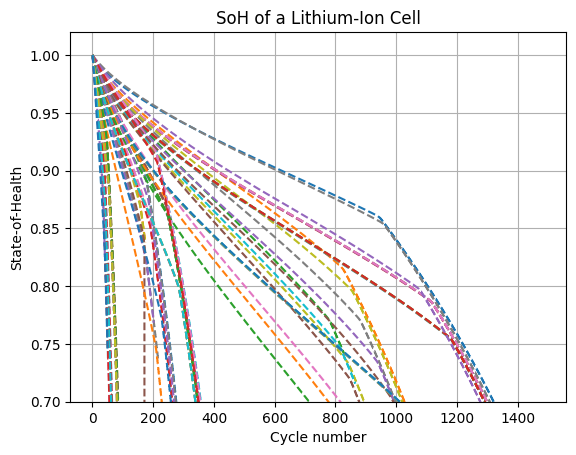

In [ ]:
df3 = pd.read_csv(f"{current_directory}/ageingresults2/Cases_for_ageing.csv")
cycles_per_day =1
for n in range(len(df)): #range(5): #
    tempC_case = df3["Temperature"][n]
    simcase = df3["Case"][n]
    dod_case = df3["DoD"][n]*0.01
    soc_case = df3["SoC"][n]*0.01
    crate = df3["C_rate"][n]
    df4 = pd.read_csv(f"{current_directory}/ageingresults2/Case{simcase}_{tempC_case}degC_{crate}C_{soc_case*100}SoC_{dod_case*100}DoD_{cycles_per_day}cycle.csv")
    plt.plot(df4["Days"], df4["Capacity Retention"],"--", label =f"Case{simcase}_{tempC_case}degC_{crate}C_{int(soc_case*100)}SoC_{int(dod_case*100)}DoD_{cycles_per_day}cycle")

# for n in range(8,15): #range(5): #
#     tempC_case = df3["Temperature"][n]
#     simcase = df3["Case"][n]
#     dod_case = df3["DoD"][n]*0.01
#     soc_case = df3["SoC"][n]*0.01
#     crate = df3["C_rate"][n]
#     df4 = pd.read_csv(f"{current_directory}/ageingresults/Case{simcase}_{tempC_case}degC_{crate}C_{soc_case*100}SoC_{dod_case*100}DoD_{cycles_per_day}cycle.csv")
#     #plt.plot(df4["Days"], df4["Capacity Retention"],marker='v', markevery=50, label =f"Case{simcase}_{tempC_case}degC_{crate}C_{int(soc_case*100)}SoC_{int(dod_case*100)}DoD_{cycles_per_day}cycle")

# df31 = pd.read_csv(f"{current_directory}/ageingresults/Cases_for_ageing2.csv")
# for n in range(5):
#     tempC_case = df31["Temperature"][n]
#     simcase = df31["Case"][n]
#     dod_case = df31["DoD"][n]*0.01
#     soc_case = df31["SoC"][n]*0.01
#     crate = df31["C_rate"][n]
#     df4 = pd.read_csv(f"{current_directory}/ageingresults/Case{simcase}_{tempC_case}degC_{crate}C_{soc_case*100}SoC_{dod_case*100}DoD_{cycles_per_day}cycle.csv")
#     plt.plot(df4["Days"], df4["Capacity Retention"],"--o", label =f"Case{simcase}_{tempC_case}degC_{crate}C_{int(soc_case*100)}SoC_{int(dod_case*100)}DoD_{cycles_per_day}cycle")
 
plt.xlabel('Cycle number')
plt.ylabel('State-of-Health')
plt.title('SoH of a Lithium-Ion Cell')
plt.ylim([0.7, 1.02])
#plt.legend(fontsize=3)
plt.grid(True)
plt.show()

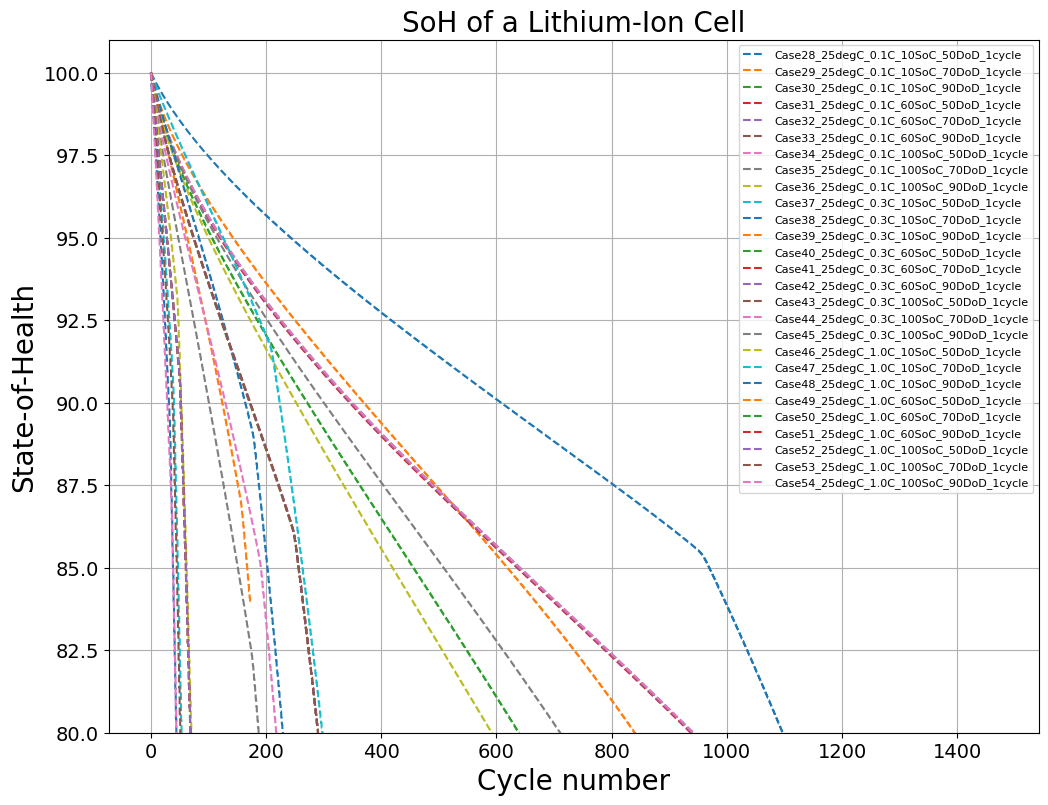

In [53]:
df3 = pd.read_csv(f"{current_directory}/ageingresults2/Cases_for_ageing.csv")
cycles_per_day =1
plt.figure(figsize=(12,9))
for n in range(27,54):#[0,44,71,80]: #range(5): #
    tempC_case = df3["Temperature"][n]
    simcase = df3["Case"][n]
    dod_case = df3["DoD"][n]*0.01
    soc_case = df3["SoC"][n]*0.01
    crate = df3["C_rate"][n]
    df4 = pd.read_csv(f"{current_directory}/ageingresults2/Case{simcase}_{tempC_case}degC_{crate}C_{soc_case*100}SoC_{dod_case*100}DoD_{cycles_per_day}cycle.csv")
    plt.plot(df4["Days"], df4["Capacity Retention"]*100,"--", label =f"Case{simcase}_{tempC_case}degC_{crate}C_{int(soc_case*100)}SoC_{int(dod_case*100)}DoD_{cycles_per_day}cycle")

plt.xlabel('Cycle number',fontsize=20)
plt.ylabel('State-of-Health',fontsize=20)
plt.title('SoH of a Lithium-Ion Cell',fontsize=20)
plt.ylim([80, 101])
plt.legend(fontsize=8)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.show()

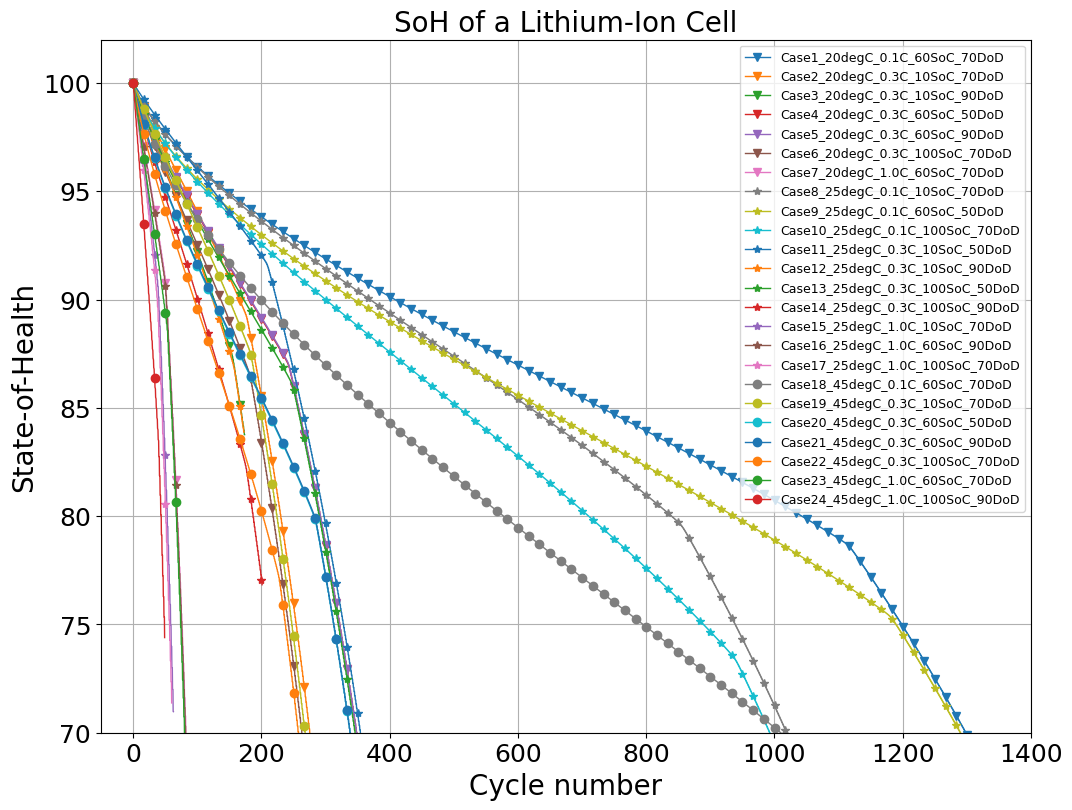

In [75]:
df3 = pd.read_csv(f"{current_directory}/ageingresults2/Cases_for_ageing.csv")
cycles_per_day =1
plt.figure(figsize=(12,9))
b =0
for m in [5,11,12,13,15,17,23]:#,29,31,33,35,37,39,43,45,47,49,51,53,59,65,67,69,71,77,81]: #range(27,54):#: #range(5): #
    b= b+1
    n = m-1
    tempC_case = df3["Temperature"][n]
    simcase = df3["Case"][n]
    dod_case = df3["DoD"][n]*0.01
    soc_case = df3["SoC"][n]*0.01
    crate = df3["C_rate"][n]
    df4 = pd.read_csv(f"{current_directory}/ageingresults2/Case{simcase}_{tempC_case}degC_{crate}C_{soc_case*100}SoC_{dod_case*100}DoD_{cycles_per_day}cycle.csv")
    plt.plot(df4["Days"], df4["Capacity Retention"]*100,marker='v', markevery=50,linewidth=1, label =f"Case{b}_{tempC_case}degC_{crate}C_{int(soc_case*100)}SoC_{int(dod_case*100)}DoD")

for m in [29,31,35,37,39,43,45,47,51,53,]: #33,49, #range(27,54):#: #range(5): #
    b= b+1
    n = m-1
    tempC_case = df3["Temperature"][n]
    simcase = df3["Case"][n]
    dod_case = df3["DoD"][n]*0.01
    soc_case = df3["SoC"][n]*0.01
    crate = df3["C_rate"][n]
    df4 = pd.read_csv(f"{current_directory}/ageingresults2/Case{simcase}_{tempC_case}degC_{crate}C_{soc_case*100}SoC_{dod_case*100}DoD_{cycles_per_day}cycle.csv")
    plt.plot(df4["Days"], df4["Capacity Retention"]*100,marker='*', markevery=50,linewidth=1, label =f"Case{b}_{tempC_case}degC_{crate}C_{int(soc_case*100)}SoC_{int(dod_case*100)}DoD")

for m in [59,65,67,69,71,77,81]: #range(27,54):#: #range(5): #
    b= b+1
    n = m-1
    tempC_case = df3["Temperature"][n]
    simcase = df3["Case"][n]
    dod_case = df3["DoD"][n]*0.01
    soc_case = df3["SoC"][n]*0.01
    crate = df3["C_rate"][n]
    df4 = pd.read_csv(f"{current_directory}/ageingresults2/Case{simcase}_{tempC_case}degC_{crate}C_{soc_case*100}SoC_{dod_case*100}DoD_{cycles_per_day}cycle.csv")
    plt.plot(df4["Days"], df4["Capacity Retention"]*100,marker='o', markevery=50,linewidth=1, label =f"Case{b}_{tempC_case}degC_{crate}C_{int(soc_case*100)}SoC_{int(dod_case*100)}DoD")

plt.xlabel('Cycle number',fontsize=20)
plt.ylabel('State-of-Health',fontsize=20)
plt.title('SoH of a Lithium-Ion Cell',fontsize=20)
plt.ylim([70, 102])
plt.xlim([-50, 1400])
plt.legend(fontsize=9)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

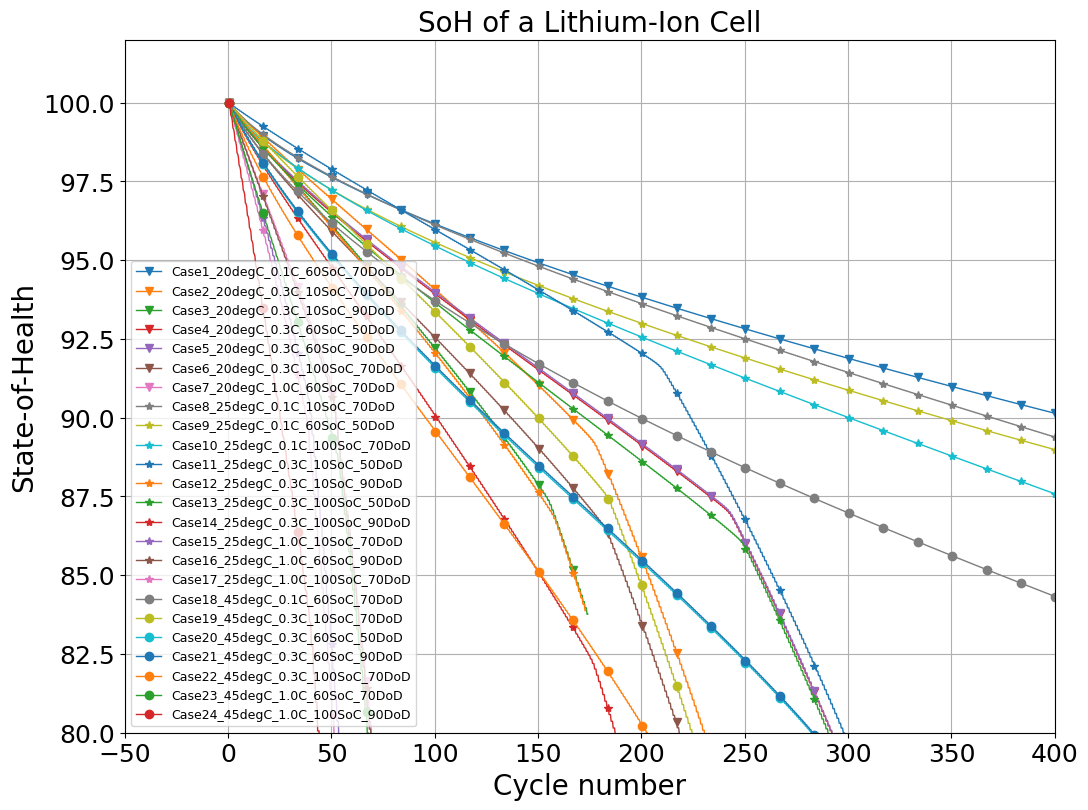

In [135]:
df3 = pd.read_csv(f"{current_directory}/ageingresults2/Cases_for_ageing.csv")
cycles_per_day =1
plt.figure(figsize=(12,9))
b =0
for m in [5,11,12,13,15,17,23]:#,29,31,33,35,37,39,43,45,47,49,51,53,59,65,67,69,71,77,81]: #range(27,54):#: #range(5): #
    b= b+1
    n = m-1
    tempC_case = df3["Temperature"][n]
    simcase = df3["Case"][n]
    dod_case = df3["DoD"][n]*0.01
    soc_case = df3["SoC"][n]*0.01
    crate = df3["C_rate"][n]
    df4 = pd.read_csv(f"{current_directory}/ageingresults2/Case{simcase}_{tempC_case}degC_{crate}C_{soc_case*100}SoC_{dod_case*100}DoD_{cycles_per_day}cycle.csv")
    plt.plot(df4["Days"], df4["Capacity Retention"]*100,marker='v', markevery=50,linewidth=1, label =f"Case{b}_{tempC_case}degC_{crate}C_{int(soc_case*100)}SoC_{int(dod_case*100)}DoD")

for m in [29,31,35,37,39,43,45,47,51,53,]: #33,49, #range(27,54):#: #range(5): #
    b= b+1
    n = m-1
    tempC_case = df3["Temperature"][n]
    simcase = df3["Case"][n]
    dod_case = df3["DoD"][n]*0.01
    soc_case = df3["SoC"][n]*0.01
    crate = df3["C_rate"][n]
    df4 = pd.read_csv(f"{current_directory}/ageingresults2/Case{simcase}_{tempC_case}degC_{crate}C_{soc_case*100}SoC_{dod_case*100}DoD_{cycles_per_day}cycle.csv")
    plt.plot(df4["Days"], df4["Capacity Retention"]*100,marker='*', markevery=50,linewidth=1, label =f"Case{b}_{tempC_case}degC_{crate}C_{int(soc_case*100)}SoC_{int(dod_case*100)}DoD")

for m in [59,65,67,69,71,77,81]: #range(27,54):#: #range(5): #
    b= b+1
    n = m-1
    tempC_case = df3["Temperature"][n]
    simcase = df3["Case"][n]
    dod_case = df3["DoD"][n]*0.01
    soc_case = df3["SoC"][n]*0.01
    crate = df3["C_rate"][n]
    df4 = pd.read_csv(f"{current_directory}/ageingresults2/Case{simcase}_{tempC_case}degC_{crate}C_{soc_case*100}SoC_{dod_case*100}DoD_{cycles_per_day}cycle.csv")
    plt.plot(df4["Days"], df4["Capacity Retention"]*100,marker='o', markevery=50,linewidth=1, label =f"Case{b}_{tempC_case}degC_{crate}C_{int(soc_case*100)}SoC_{int(dod_case*100)}DoD")

plt.xlabel('Cycle number',fontsize=20)
plt.ylabel('State-of-Health',fontsize=20)
plt.title('SoH of a Lithium-Ion Cell',fontsize=20)
plt.ylim([80, 102])
plt.xlim([-50, 400])
plt.legend(fontsize=9)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(True)
plt.show()

In [ ]:


# Q1 = sim1.solution.summary_variables["Capacity [A.h]"]
# cycle1 = sim1.solution.summary_variables["Cycle number"]
# df2 = {}
# df2 = pd.DataFrame(df2)
# df2["Days"] =cycle1/(steps_total*cycles_per_day)
# df2.to_csv(f"{current_directory}/ageingresults/Case{simcase}_{tempC_case}degC_{crate}C_{soc_case*100}SoC_{dod_case*100}DoD_{cycles_per_day}cycle.csv")

# plt.plot(cycle1/(steps_total*cycles_per_day)/days_per_year,Q1/Q1[0],"--", label =f"Case{simcase}_{tempC_case}degC_{crate}C_{int(soc_case*100)}SoC_{int(dod_case*100)}DoD_{cycles_per_day}cycle")
# plt.legend(fontsize=6)

# plt.xlabel("Year")
# plt.ylabel("Capacity retention")
# plt.xticks(fontsize =16)
# plt.yticks(fontsize = 16)
# plt.show()

# df_conditions["simcase"] = simcase_list
# df_conditions["Experiment"] = experiment_list
# df_conditions["n_steps"] = no_steps_list

# df_conditions.to_csv(f"{current_directory}/ageingresults/experiments.csv")

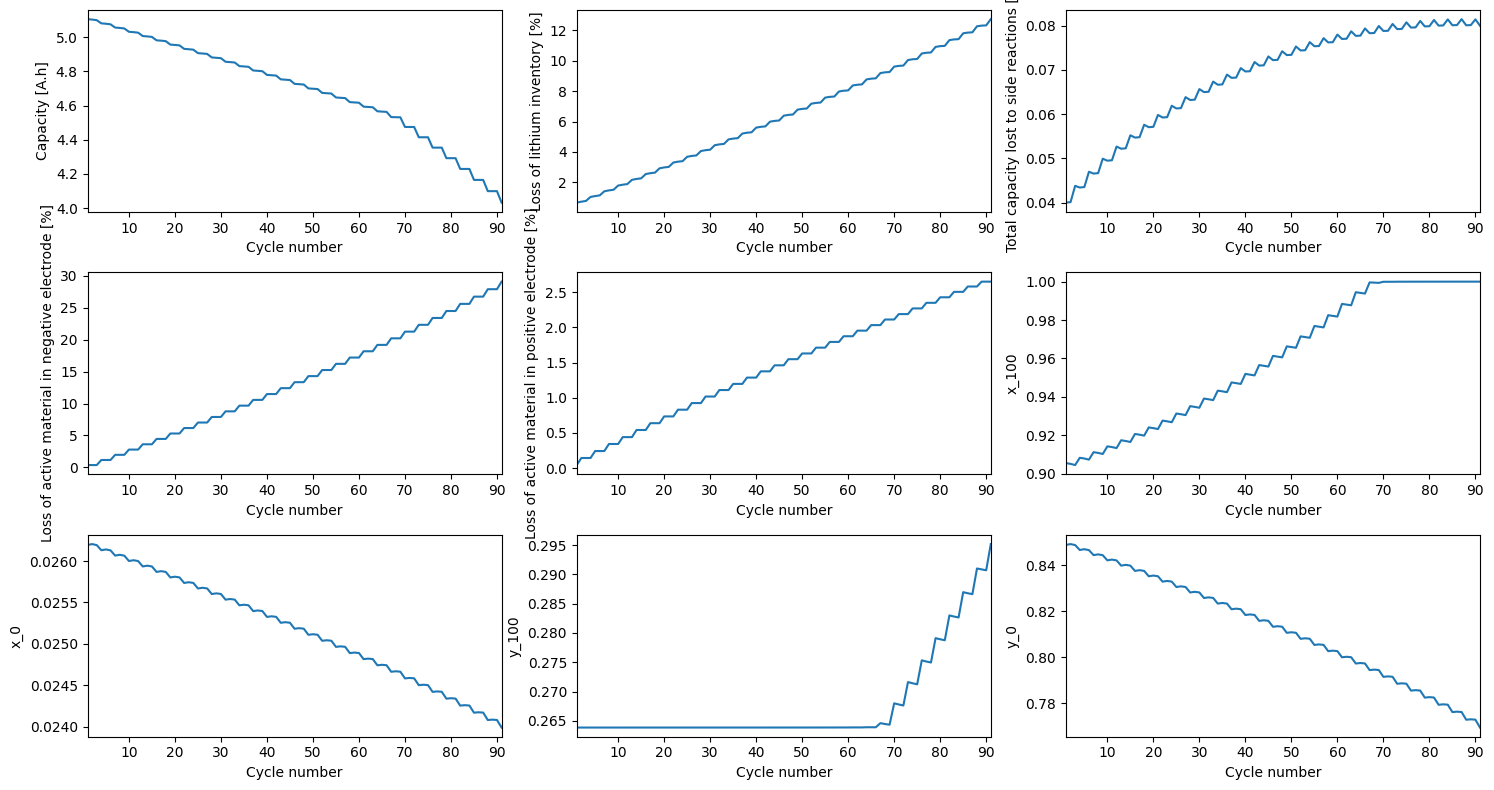

array([[<Axes: xlabel='Cycle number', ylabel='Capacity [A.h]'>,
        <Axes: xlabel='Cycle number', ylabel='Loss of lithium inventory [%]'>,
        <Axes: xlabel='Cycle number', ylabel='Total capacity lost to side reactions [A.h]'>],
       [<Axes: xlabel='Cycle number', ylabel='Loss of active material in negative electrode [%]'>,
        <Axes: xlabel='Cycle number', ylabel='Loss of active material in positive electrode [%]'>,
        <Axes: xlabel='Cycle number', ylabel='x_100'>],
       [<Axes: xlabel='Cycle number', ylabel='x_0'>,
        <Axes: xlabel='Cycle number', ylabel='y_100'>,
        <Axes: xlabel='Cycle number', ylabel='y_0'>]], dtype=object)

In [40]:
pybamm.plot_summary_variables(sim1.solution)

In [ ]:
model.variable_names()